In [24]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pickle

In [25]:
!pip install opencv-contrib-python==4.4.0.44

In [26]:

from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm 
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DownloadProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

""" 
    check if the data (zip) file is already downloaded
    if not, download it from "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" and save as cifar-10-python.tar.gz
"""
if not isfile('cifar-10-python.tar.gz'):
    with DownloadProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


In [27]:
def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        # note the encoding type is 'latin1'
        batch = pickle.load(file, encoding='latin1')
        
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    labels = batch['labels']
        
    return features, labels

In [28]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [29]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [30]:
def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
   
    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch #{}:'.format(batch_id))
    print('# of Samples: {}\n'.format(len(features)))
    
    label_names = load_label_names()
    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), value))
    
    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    
    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    
    plt.imshow(sample_image)


Stats of batch #3:
# of Samples: 10000

Label Counts of [0](AIRPLANE) : 994
Label Counts of [1](AUTOMOBILE) : 1042
Label Counts of [2](BIRD) : 965
Label Counts of [3](CAT) : 997
Label Counts of [4](DEER) : 990
Label Counts of [5](DOG) : 1029
Label Counts of [6](FROG) : 978
Label Counts of [7](HORSE) : 1015
Label Counts of [8](SHIP) : 961
Label Counts of [9](TRUCK) : 1029

Example of Image 7:
Image - Min Value: 12 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 3 Name: cat


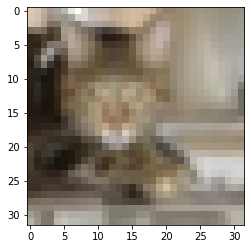

In [31]:
batch_id = 3
sample_id = 7
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

In [32]:
def readData(cifar10_dataset_folder_path, batch_id):
    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
    return features, labels

In [33]:
train_images = []
train_labels = []
for i in range (1,5):
    t,l = readData(cifar10_dataset_folder_path,i)
    train_images.extend(t)
    train_labels.extend(l)


In [34]:
np.shape(train_images)

(40000, 32, 32, 3)

In [35]:
def getDetector(mode):
  detector = 0
  if mode == 'sift': detector = cv2.SIFT_create()
  if mode == 'surf' : detector = cv2.xfeatures2d.SURF_create()
  if mode =='brisk' : detector = cv2.BRISK_create()
  if mode == 'akaze' :  detector = cv2.AKAZE_create() 
  return detector

In [36]:
detector = getDetector('sift')

In [62]:
def get_features(image, detector):
  keypoints, descriptors = detector.detectAndCompute(image, None)
  return keypoints, descriptors

In [63]:
def get_features(image, detector):
  keypoints, descriptors = detector.detectAndCompute(image, None)
  return keypoints, descriptors

In [64]:
def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [65]:
from sklearn.cluster import KMeans 

i = 0;
descriptors_lst = []
for img in train_images:
  img = gray(img)
  keypoints, descriptors = get_features(img,detector)
  
  if descriptors is not None: descriptors_lst.extend(descriptors)
  else: i=i+1

In [66]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

In [67]:
def get_histogram(images, detector, kmeans, labels):
    lst = []
    y = []
    i = 0;
    for image in images:
        image = gray(image)
        keypoint, descriptor = get_features(image, detector)
        if (descriptor is not None):
            histogram = build_histogram(descriptor.astype(float), kmeans)
            lst.append(histogram) 
            y.append(labels[i])
        i = i + 1
    return lst, y

In [68]:
kmeans = KMeans(n_clusters = 512)
kmeans.fit(descriptors_lst)

KeyboardInterrupt: ignored

In [ ]:
x_train, y_train = get_histogram(train_images, detector, kmeans, train_labels)

In [ ]:
np.shape(x_train)

In [ ]:
test_images, testlabels = readData(cifar10_dataset_folder_path, 5)

In [ ]:
x_test, y_test = get_histogram(test_images, detector, kmeans, testlabels)

In [ ]:
np.shape(x_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
scaler = StandardScaler()

In [ ]:
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)                               

In [ ]:
clf = SVC(kernel = 'poly', degree = 3, gamma='auto')

In [ ]:
clf.fit(x_train, y_train)

In [ ]:
clf.score(x_test,y_test) * 100                 

In [ ]:
lr = LogisticRegression(penalty = 'l2')

In [ ]:
lr.fit(x_train,y_train)

In [ ]:
lr.score(x_test,y_test) * 100

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=10)

In [ ]:
neigh.fit(x_train,y_train)

In [ ]:
neigh.score(x_test[:2000],y_test[:2000]) * 100